In [14]:
import numpy as np
import cvxpy as cp
import itertools as it
import scipy.linalg as spla
import matplotlib.pyplot as plt
import pennylane as qml

Basic functions and utils

In [15]:
def pauli_basis(n):
    I = np.eye(2).astype(complex)
    X = np.array([[0, 1], [1, 0]], complex)
    Y = np.array([[0, -1j], [1j, 0]], complex)
    Z = np.array([[1, 0], [0, -1]], complex)
    basis = {
        "labels": [],
    }
    b = []
    for comb in list(it.product([0, 1, 2, 3], repeat=n))[1:]:
        p = 1.
        basis["labels"].append(comb)
        for c in comb:
            if c == 0:
                p = np.kron(p, I)
            elif c == 1:
                p = np.kron(p, X)
            elif c == 2:
                p = np.kron(p, Y)
            elif c == 3:
                p = np.kron(p, Z)
        b.append(p)
    basis["basis"] = np.stack(b)
    return basis

def two_body_projection_indices(basis):
    basis_indices = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            basis_indices.append(1)
        else:
            basis_indices.append(0)
    return basis_indices

def two_body_projection(theta, basis):
    indices = two_body_projection_indices(basis)
    return np.array([t * indices[i] for i,t in enumerate(theta)])
    
def two_body_restriction_basis(basis):
    new_basis = {
        "labels": [],
    }
    basis_elements = []
    for i, b in enumerate(basis["labels"]):
        if len(np.nonzero(b)[0]) <= 2:
            new_basis["labels"].append(b)
            basis_elements.append(np.array(basis["basis"][i]))
    new_basis["basis"] = np.stack(basis_elements)
    return new_basis

def specific_basis_terms(basis, specific_labels, ts):
    theta = []
    for l in basis["labels"]:
        if l in specific_labels:
            theta.append(ts[specific_labels.index(l)])
        else:
            theta.append(0)
    return np.array(theta)
    
def hamiltonian_from_parameters(parameters, basis):
    return np.einsum("ijk,i->jk", basis, parameters)

def unitary_from_parameters(parameters, basis):
    h = hamiltonian_from_parameters(parameters, basis)
    return spla.expm(1.j*h)

def parameters_from_hamiltonian(hamiltonian, basis):
    return np.real(np.einsum("ijk, kj->i", basis, hamiltonian)) / (len(hamiltonian[0]))

def unitary_fidelity(U1, U2):
    return np.abs(np.trace(U1.conj().T @ U2))/len(U1[0])

def phi_fidelity(phi, phi_basis, U2):
    phi_H = hamiltonian_from_parameters(phi, phi_basis)
    phi_U = spla.expm(1.j * phi_H)
    return unitary_fidelity(phi_U, U2)

def geodesic_ham(U, V):
    gamma = -1.j * spla.logm(V @ U.conj().T)
    return gamma

def plot_parameters(labels, parameters, title=False, figsize=[14,6]):
    labels = ["".join(map(str, l)) for l in labels]
    fig, ax = plt.subplots(figsize=figsize)
    ax.bar(labels,parameters)
    ax.grid()
    if title:
        plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    
def plot_fidelities(steps, fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    ax.plot(steps, fidelities)
    if title:
        plt.title(title)
    plt.show()
    
def plot_multi_fidelities(multi_steps, multi_fidelities, title=False):
    fig, ax = plt.subplots(figsize=[12,6])
    for i, fidelities in enumerate(multi_fidelities):
        fid = [1 - f for f in fidelities] 
        ax.plot(multi_steps[i], fid)
    if title:
        plt.title(title)
    ax.set_yscale('log')
    ax.set_xlabel("Step")
    ax.set_ylabel("1 - fidelity")
    plt.show()
    
def plot_direction_indices(indices, title=False):
    plt.hist(indices, bins=len(indices))
    if title:
        plt.title(title)
    plt.show()

Step size map, convex optimisation for linear combination of omegas, and constructing new phi vectors

In [21]:
def step_size_map(fid):
    return (1-fid**2)/2 + 0.001

def linear_combination_coeffs(combination_vectors, target_vector):
    x = cp.Variable(combination_vectors.shape[0])
    cost = cp.sum_squares(combination_vectors.T @ x - target_vector)
    prob = cp.Problem(cp.Minimize(cost))
    prob.solve()
    return x.value

def construct_new_phi(phi, phi_basis, index, target_V, step_size):
    delta_phi = np.zeros(len(phi))
    delta_phi[index] = step_size
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
    else:
        new_phi = new_phi_plus
    return new_phi

def construct_new_phi_full(phi, phi_basis, delta_phi, target_V, step_size):
    delta_phi = step_size * delta_phi
    new_phi_minus = phi - delta_phi
    new_phi_plus = phi + delta_phi
    if phi_fidelity(new_phi_minus, phi_basis["basis"], target_V) > phi_fidelity(new_phi_plus, phi_basis["basis"], target_V):
        new_phi = new_phi_minus
    else:
        new_phi = new_phi_plus
    return new_phi

Parameter update function

In [22]:
def geodesic_direction_update_step(target_V, phi, phi_basis, step_size=0.01, precision=0.9999, step_count=(None,None)):
    # Step 0: find the unitary from phi
    phi_H = hamiltonian_from_parameters(phi, phi_basis["basis"])
    phi_U = spla.expm(1.j * phi_H)
    
    # Step 1: find the geodesic between phi_U and target_V
    gamma = geodesic_ham(phi_U, target_V)
    gamma_phi = parameters_from_hamiltonian(gamma, phi_basis["basis"])
    
    # Step 2: find the Omegas
    su = qml.SpecialUnitary(phi, [i for i in range(nqubits)])
    omegas = su.get_one_parameter_generators(interface="jax")
    omega_phis = np.array([parameters_from_hamiltonian(omega, phi_basis["basis"]) for omega in omegas])

    # Step 3: find the Omega index that is closest to the geodesic gamma with the two-body restriction
    inner_products = []
    projected_indices = two_body_projection_indices(phi_basis)
    for i, omega in enumerate(omegas):
        if projected_indices[i]:
            inner_products.append(unitary_fidelity(omega, gamma))
        else:
            inner_products.append(0)
    inner_products = np.array(inner_products)
    args_sorted = np.flip(np.argsort(inner_products))

    # Step 4: Find a linear combination of Omegas that gives the geodesic and update parameters
    coeffs = linear_combination_coeffs(omega_phis, gamma_phi)
    if coeffs is None:
        print(f"[{step_count[0]}/{step_count[1]}] Didn't find coefficients for Omega direction; giving it a push in random direction.", end='\r')
        new_phi = two_body_projection(np.array(phi) + (step_size * np.random.rand(len(phi_basis["basis"])) - 1/2), phi_basis)
        omega_ind = 1
    else:
        proj_coeffs = np.multiply(projected_indices, coeffs)
        proj_normed_coeffs = proj_coeffs / np.sqrt(np.dot(proj_coeffs, proj_coeffs))

        # Apply a small push in the right direction to give a new phi
        new_phi = construct_new_phi_full(phi, phi_basis, proj_normed_coeffs, target_V, step_size)
        fidelity_phi = phi_fidelity(phi, phi_basis["basis"], target_V)
        fidelity_new_phi = phi_fidelity(new_phi, phi_basis["basis"], target_V)

        omega_ind = 0
        if phi_fidelity(new_phi, phi_basis["basis"], target_V) > precision:
            print(f"\n[{step_count[0]}/{step_count[1]}] Solution found!")
        elif (not np.isclose(fidelity_phi, fidelity_new_phi)) and (fidelity_new_phi > fidelity_phi):
            pass
        else:
            print(f"[{step_count[0]}/{step_count[1]}] [Fidelity = {fidelity_phi}] Omega geodesic gave a negative fidelity update for this step.", end='\r')
            omega_ind = 1
    
    return new_phi, omega_ind

Update step management 

In [23]:
def rand_init_fidelities(target_V, basis, num_steps, step_size, update_func=geodesic_direction_update_step, precision=0.9999):
    # Initialise a random phi starting point and compute its fidelity
    phis = [two_body_projection(np.random.rand(len(basis["basis"])), basis)]
    fidelities = [phi_fidelity(phis[0], basis["basis"], target_V)]
    
    # Perform num_steps geodesic updates of size step_size
    steps = list(range(num_steps+1))
    indices = []
    for step in steps[1:]:
        step_size = step_size_map(fidelities[-1])
        new_phi, index = update_func(target_V, phis[-1], basis, step_size=step_size, precision=precision, step_count=(step,num_steps))
        indices.append(index)
        fidelities.append(phi_fidelity(new_phi, basis["basis"], target_V))
        phis.append(new_phi)
        if phi_fidelity(new_phi, basis["basis"], target_V) > precision:
            break
    return steps[:len(fidelities)], fidelities, phis, indices

Some gates

In [24]:
Vtoff = np.array([[1,0,0,0,0,0,0,0],
                  [0,1,0,0,0,0,0,0],
                  [0,0,1,0,0,0,0,0],
                  [0,0,0,1,0,0,0,0],
                  [0,0,0,0,1,0,0,0],
                  [0,0,0,0,0,1,0,0],
                  [0,0,0,0,0,0,0,1],
                  [0,0,0,0,0,0,1,0]])

w = np.exp(1.j * 2 * np.pi / 8)
Vqft = np.array([[1,1,1,1,1,1,1,1],
                 [1, w, w**2, w**3, w**4, w**5, w**6, w**7],
                 [1, w**2, w**4, w**6, w**8, w**10, w**12, w**14],
                 [1, w**3, w**6, w**9, w**12, w**15, w**18, w**21],
                 [1, w**4, w**8, w**12, w**16, w**20, w**24, w**28],
                 [1, w**5, w**10, w**15, w**20, w**25, w**30, w**35],
                 [1, w**6, w**12, w**18, w**24, w**30, w**36, w**42],
                 [1, w**7, w**14, w**21, w**28, w**35, w**42, w**49]])

w4 = np.exp(1.j * 2 * np.pi / 16)
Vqft4 = np.array([[w4**(i*j) for i in range(16)] for j in range(16)])

w5 = np.exp(1.j * 2 * np.pi / 32)
Vqft5 = np.array([[w5**(i*j) for i in range(32)] for j in range(32)])

Random initialisation and then plot of fidelities against step

[38/1000] [Fidelity = 0.9486233190402964] Omega geodesic gave a negative fidelity update for this step.
[75/1000] Solution found!
Final fidelity = 0.999025674630178
[18/1000] [Fidelity = 0.8287231548531678] Omega geodesic gave a negative fidelity update for this step.
[83/1000] Solution found!
Final fidelity = 0.9991098311722293
[46/1000] [Fidelity = 0.9171660154828953] Omega geodesic gave a negative fidelity update for this step..
[95/1000] Solution found!
Final fidelity = 0.9990899101989731


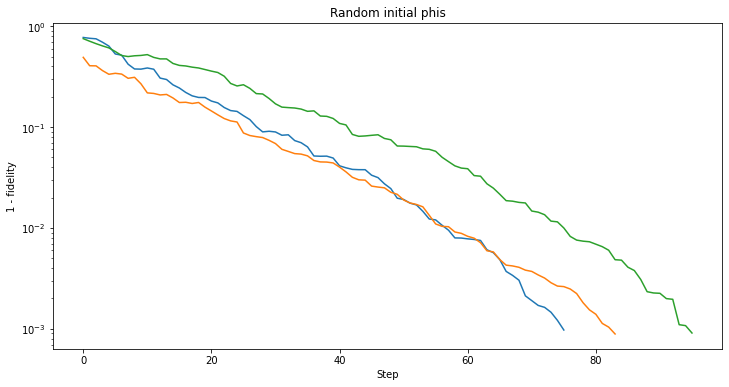

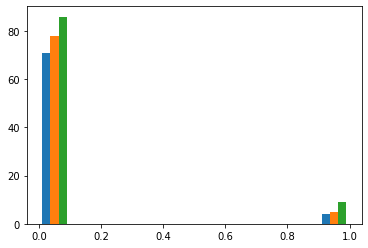

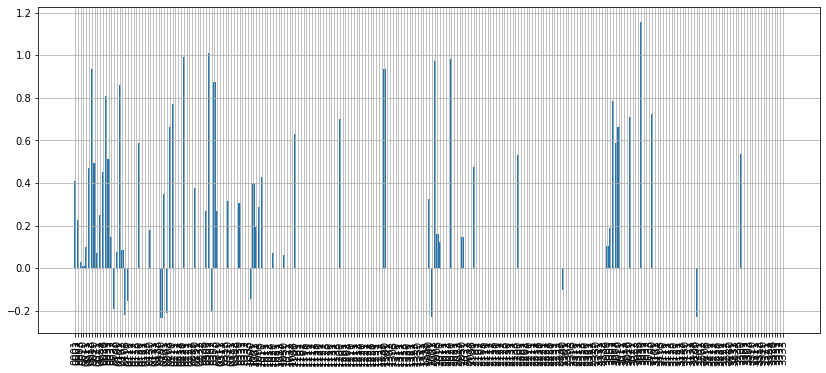

In [25]:
nqubits=4
basis_full = pauli_basis(nqubits)
basis_restricted = two_body_restriction_basis(basis_full)
num_rand_interations = 3

multi_fidelities = []
multi_steps = []
multi_indices = []
for _ in range(num_rand_interations):
    steps, fidelities, phis, indices = rand_init_fidelities(Vqft4, basis_full, num_steps=1000, step_size=0.001, update_func=geodesic_direction_update_step, precision=0.999)    
    print(f"Final fidelity = {fidelities[-1]}")
    multi_fidelities.append(fidelities)
    multi_steps.append(steps)
    multi_indices.append(indices)

plot_multi_fidelities(multi_steps, multi_fidelities, title="Random initial phis")
plt.hist(multi_indices)
plot_parameters(basis_full["labels"],phis[-1])